<a href="https://colab.research.google.com/github/faingold/mario-deepRL/blob/main/Mario_DeepRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning Mario
This notebook goes through implementing and comparing the performance of several Deep Reinforcement Learning agents playing Mario Super Smash Bros. It includes the DDQN and Dueling DDQN agents. 

A simple environment [CartPole](https://gym.openai.com/envs/CartPole-v0/) is used to verify the correctness of agent implementations. 

**Choose the environment:**

In [1]:
# Choose one:
mario_env_name = "Mario"
cartpole_env_name = "CartPole"

env_name = cartpole_env_name

## First, dependencies
Packages for rendering gym environment from the remote server where the notebook is executed. It will capture a video of the gym there and display it inline. 

In [2]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [3]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1043'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1043'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

Gym packages including CartPole and Mario.

In [5]:
!pip install gym gym-super-mario-bros > /dev/null 2>&1

In [6]:
# This cell is temporary. It is needed to get the DQN example from PyTorch to work

%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils > /dev/null 2>&1

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* > /dev/null 2>&1

In [7]:
import pyvirtualdisplay

display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = display.start()

In [8]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # only display errors

import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

Now, the actual computational packages.

In [9]:
import math
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

and some python utilities

In [10]:
from collections import namedtuple
from itertools import count

and mounting the drive for saving models and loading modules

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


and some other set up

In [12]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Environment Rendering

In [13]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video(i=-1):
  mp4list = glob.glob('video/*.mp4')
  print(mp4list)
  if len(mp4list) > 0:
    mp4 = mp4list[i]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Mario Environment

In [14]:
if env_name == mario_env_name:
    env = wrap_env(gym_super_mario_bros.make('SuperMarioBros-v2'))
    env = JoypadSpace(env, SIMPLE_MOVEMENT)

    def get_screen():
        # Images comes as HWC, transpose to CHW
        screen = env.render(mode='rgb_array').transpose((2, 0, 1))
        # Normalize
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Add a batch dimension BCHW (required for convolutional layers)
        return screen.unsqueeze(0).to(device)

    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
            interpolation='none')
    plt.title('Example extracted screen')
    plt.show()

## Cartpole Environment

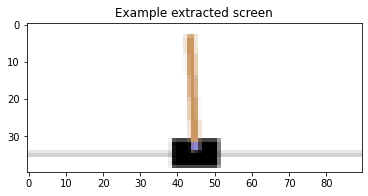

In [15]:
if env_name == cartpole_env_name:
    env = gym.make('CartPole-v0').unwrapped
    env = wrap_env(env)
    resize = T.Compose([T.ToPILImage(),
                        T.Resize(40, interpolation=Image.CUBIC),
                        T.ToTensor()])


    def get_cart_location(screen_width):
        world_width = env.x_threshold * 2
        scale = screen_width / world_width
        return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

    def get_screen():
        # Returned screen requested by gym is 400x600x3, but is sometimes larger
        # such as 800x1200x3. Transpose it into torch order (CHW).
        screen = env.render(mode='rgb_array').transpose((2, 0, 1))
        # Cart is in the lower half, so strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
        view_width = int(screen_width * 0.6)
        cart_location = get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescale, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        return resize(screen).unsqueeze(0).to(device)


    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
            interpolation='none')
    plt.title('Example extracted screen')
    plt.show()

## Agent in parts

### Replay Memory


In [16]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

###Models: DQN, Dueling DQN

In [17]:
# Helper for calculating kernel size after a convolution
def conv2d_size_out(size, kernel_size = 5, stride = 2):
    return (size - (kernel_size - 1) - 1) // stride  + 1

####DQN

In [18]:
class DQN(nn.Module):
    # h, w: height and width of the input image
    # outputs: the number of outputs, corresponds to the size of the action space
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32

        self.fc = nn.Linear(linear_input_size, outputs)

    # Returns a score for each action in the current state
    # State x is assumed to be a 3 channel image
    def forward(self, x):
        conv_out = self.conv(x)
        # Make each item in the batch a single row vec
        return self.fc(conv_out.view(conv_out.size(0), -1))

#### Dueling DQN

In [19]:
class DuelingDQN(nn.Module):
    # h, w: height and width of the input image
    # outputs: the number of outputs, corresponds to the size of the action space
    def __init__(self, h, w, outputs):
        super(DuelingDQN, self).__init__()
        self.outputs = outputs

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32

        # Multiple values corresponding to actions
        self.advantage = nn.Sequential(
            nn.Linear(linear_input_size, 256),
            nn.ReLU(),
            nn.Linear(256, outputs)
        )

        # A single value corresponding to the state
        self.value = nn.Sequential(
            nn.Linear(linear_input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    # Returns a score for each action in the current state
    # State x is assumed to be a 3 channel image
    def forward(self, x):
        conv_out = self.conv(x)
        # Make each item in the batch a single row vec
        conv_out = conv_out.view(conv_out.size(0), -1)

        value = self.value(conv_out).expand(x.size(0), self.outputs)
        adv = self.advantage(conv_out)

        # value = self.fc2_value(value).expand(x.size(0), self.outputs)

        advAverage = adv.mean(1).unsqueeze(1).expand(x.size(0), self.outputs)
        Q = value + adv - advAverage

        return Q

### Hyper Parameters

In [20]:
# Hyper params
BATCH_SIZE = 128
# Discount of future rewards
GAMMA = 0.999
# Epsilon greedy exploration
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 100 # 5000 good for 100k
# Rate of target (frozen) model weight updates
TARGET_UPDATE = 100
MEMORY_SIZE = 10000

In [21]:
# Computes threshold based on the current step
def get_epsilon_threshold(step):
    return EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * step / EPS_DECAY)

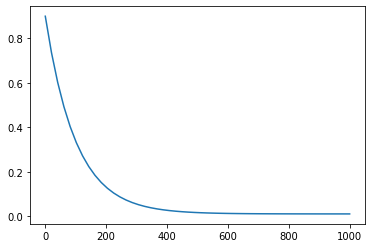

In [22]:
# Show how epsion will decay
steps = np.linspace(0, 1000)
fig = plt.figure()
plt.plot(steps, [get_epsilon_threshold(step) for step in steps])

### Agent Body

In [23]:
class Agent():
    def __init__(self, env, dueling_DQN = True, DDQN = True, PER = True):
        # TODO: init from saved model weights like online_model.load_state_dict(torch.load(path))
        # TODO: too much stuff in initializer?

        # Maybe it shouldn't be here
        self.env = env

        _, _, h, w = get_screen().shape
        # Target is the offline network that stays frozen and gets updated
        # every TARGET_UPDATE
        if dueling_DQN:
            self.online_model = Dueling_DQN(h, w, env.action_space.n)
            self.target_model = Dueling_DQN(h, w, env.action_space.n)
        else:
            self.online_model = DQN(h, w, env.action_space.n)
            self.target_model = DQN(h, w, env.action_space.n)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.online_model = self.online_model.to(device)
        self.target_model = self.target_model.to(device)
            
        self.optimizer = optim.RMSprop(self.online_model.parameters())

        self.DDQN = DDQN

        if PER:
            # TODO: PER memory
            print("no PER here")
            self.memory = ReplayMemory(MEMORY_SIZE)
        else:
            self.memory = ReplayMemory(MEMORY_SIZE)

        # Keep track to adjust exploration (epsion) and update target model
        self.steps_done = 0

        # Save model weights at these intervals
        self.save_interval = 1000

    # Makes model good
    def optimize_model(self):
        # TODO: I assume PER is involved here as well
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        # This converts batch-array of Transitions to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        if self.DDQN:
            # Compute: Reward + (Gamma * max_wrt_actions(Q_target(s_t+1, arg_max_wrt_actions(Q_online(s_t+1, a)))))
            # 1. arg_max_wrt_actions(Q_online(s_t+1, a))
            online_action_inds = self.online_model(non_final_next_states).argmax(1)
            # 2. Q_target(s_t+1, all_actions)
            target_all_action_q = self.target_model(non_final_next_states)
            # 3. Q_target(s_t+1, arg_max_wrt_actions(Q_online(s_t+1, a)))
            target_state_action_q = torch.zeros(BATCH_SIZE, device=device)
            target_state_action_q[non_final_mask] = target_all_action_q.gather(1, online_action_inds.unsqueeze(-1))[0].detach()
            # 4. Reward + (Gamma * max_wrt_actions(Q_target(s_t+1, arg_max_wrt_actions(Q_online(s_t+1, a)))))
            target_state_action_q = (target_state_action_q * GAMMA) + reward_batch

        else:
            # Compute: Reward + (Gamma * max_wrt_actions(Q_target(s_t+1, a)))
            # 1. max_wrt_actions(Q_target(s_t+1, a))
            target_state_action_q = torch.zeros(BATCH_SIZE, device=device)
            target_state_action_q[non_final_mask] = self.target_model(non_final_next_states).max(1)[0].detach()
            # 2. Reward + (Gamma * max_wrt_actions(Q_target(s_t+1, a)))
            target_state_action_q = (target_state_action_q * GAMMA) + reward_batch
            
        # Compute Q(s_t, a) and select Q values corresponding to the taken actions.
        online_state_action_q = self.online_model(state_batch).gather(1, action_batch)

        # Compute Huber loss
        loss = F.smooth_l1_loss(online_state_action_q, target_state_action_q.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.online_model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


    # Uses epsilon greedy with annealing: chances of choosing a random action are
    # high in the beginning, but get lower further into training
    # TODO: try reward based epsilon decay https://aakash94.github.io/Reward-Based-Epsilon-Decay/
    def select_action(self, state):
        self.steps_done += 1

        if (self.steps_done % TARGET_UPDATE == 0):
            self.update_target_model()
        if (self.steps_done % self.save_interval == 0):
            self.save_model()

        if random.random() > get_epsilon_threshold(self.steps_done):
            with torch.no_grad():
                # Pick action with the largest expected reward
                return self.online_model(state).max(1)[1].view(1, 1)
        else:
            # return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    def save_model(self, model_name="Mario_RL.pt"):
        # TODO: don't overwrite models, save other info like graphs?
        path = f"/content/gdrive/My Drive/{model_name}"
        torch.save(self.online_model.state_dict(), path)

    def update_target_model(self):
        self.target_model.load_state_dict(self.online_model.state_dict())

    def remember(self, transition):
        # TODO: PER ?
        self.memory.push(*transition)



### Training


In [24]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration (steps)')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)

###Training loop


Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.




In [25]:
agent = Agent(env, False, True, False)

In [26]:
num_episodes = 10

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    env.render()

    if env_name == mario_env_name:
        state = get_screen()
    else:
        # CartPole needs to capture motion
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen

    for t in count():
        # Select and perform an action
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        # Give negative reward for losing the game
        # TODO: works for cartpole but Mario??
        reward = reward if not done or t == 499 else -10
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if env_name == cartpole_env_name:
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

        # Store the transition in memory
        agent.remember((state, action, next_state, reward))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        agent.optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
env.close()
plt.ioff()
plt.show()
show_video()

Complete


<Figure size 432x288 with 0 Axes>

['video/openaigym.video.0.6533.video000000.mp4', 'video/openaigym.video.0.6533.video000001.mp4', 'video/openaigym.video.0.6533.video000008.mp4']
